## 和get ratio一样的cut

展示不同gamma下的pxp - pxn图形



In [3]:
import os
import numpy as np
import math

In [4]:
#  得到SMDIR环境变量
smdir = os.getenv('SMSIMDIR')


caculate y polarization first



In [ ]:
pols = ["ynp", "ypn"]
count_px_pbiggger = 0
count_px_nbiggger = 0
bmin = 5
bmax = 10
target = "Pb208"
R_list = []
gammas = ["050", "060", "070", "080"]
# 初始化 pxp_values 字典
pxp_values = {gamma: [] for gamma in gammas}
pxn_values = {gamma: [] for gamma in gammas}

phi_values = {gamma: [] for gamma in gammas}
rpphi_values = {gamma: [] for gamma in gammas}

for gamma in gammas:
    # for b in range(bmin, bmax + 1):
    for p in pols:
        # 构建文件路径 弄成相对于SMDIR的路径
        folder = os.path.join(smdir, f"data/qmdrawdata/qmdrawdata/y_pol/phi_random/d+{target}E190g{gamma}{p}/")
        filename = f"dbreak.dat"
        filepath = os.path.join(folder, filename)

        # 检查文件是否存在并打开
        if not os.path.isfile(filepath):
            print(f"Error opening file: {filepath}")
            exit(1)  # 返回非零值表示错误

        with open(filepath, 'r') as inputfile:
            # 读取文件头信息
            info = inputfile.readline().strip()
            header = inputfile.readline().strip()

            # 读取数据
            for line in inputfile:
                data = line.split()
                if len(data) < 7:
                    continue  # 跳过格式不正确的行
                eventNo = int(data[0])

                pxp_orig, pyp_orig, pzp_orig = map(float, data[1:4])
                pxn_orig, pyn_orig, pzn_orig = map(float, data[4:7])

                b, rpphi_deg = map(float, data[7:9])

                # 使用numpy数组创建初始的3D向量
                # pp_orig 代表粒子 p 的原始动量向量
                # pn_orig 代表粒子 n 的原始动量向量
                pp_orig = np.array([pxp_orig, pyp_orig, pzp_orig], dtype=float)
                pn_orig = np.array([pxn_orig, pyn_orig, pzn_orig], dtype=float)

                # 计算两个粒子动量之和的方位角 (phi)，这个角度将用于后续的旋转操作
                # (pp_orig + pn_orig) 是两个粒子动量的矢量和
                # [1] 是和向量的 y 分量, [0] 是和向量的 x 分量
                # phi_for_rotation 是这个和向量在 xy 平面上的角度
                vec_sum_orig = pp_orig + pn_orig
                phi_for_rotation = np.arctan2(vec_sum_orig[1], vec_sum_orig[0])

                # 第一个条件判断：
                # 1. 两个粒子原始 y 动量分量之差的绝对值小于 150
                # 2. 两个粒子原始动量 x,y 分量之和的平方和 (即和向量在xy平面投影的模平方) 大于 2500
                #    (pxn_orig + pxp_orig)**2 + (pyn_orig + pyp_orig)**2  等价于 vec_sum_orig[0]**2 + vec_sum_orig[1]**2
                condition1_part1 = abs(pyp_orig - pyn_orig) < 150
                condition1_part2 = (vec_sum_orig[0]**2 + vec_sum_orig[1]**2) > 2500
                
                if condition1_part1 and condition1_part2:
                    # 旋转操作
                    # 定义绕 Z 轴旋转的旋转矩阵。旋转角度为 -phi_for_rotation
                    angle_rad = -phi_for_rotation
                    cos_a = np.cos(angle_rad)
                    sin_a = np.sin(angle_rad)
                    
                    R_z = np.array([
                        [cos_a, -sin_a, 0],
                        [sin_a,  cos_a, 0],
                        [0,      0,     1]
                    ])

                    # 将原始动量向量 pp_orig 和 pn_orig 进行旋转
                    pp_rotated = R_z @ pp_orig
                    pn_rotated = R_z @ pn_orig

                    # 更新 pxp, pyp, pzp 和 pxn, pyn, pzn 为旋转后的向量分量
                    # 这些变量现在存储的是旋转后的动量分量
                    pxp, pyp, pzp = pp_rotated[0], pp_rotated[1], pp_rotated[2]
                    pxn, pyn, pzn = pn_rotated[0], pn_rotated[1], pn_rotated[2]

                    # 第二个条件判断：
                    # 1. 旋转后两个粒子的 x 动量分量之和小于 200
                    # 2. pi 与用于旋转的 phi_for_rotation 的绝对值之差小于 0.2
                    #    这通常用于检查 phi_for_rotation 是否接近 pi 或 -pi (即反向散射)
                    condition2_part1 = (pxp + pxn) < 200
                    condition2_part2 = (np.pi - abs(phi_for_rotation)) < 0.2
                    
                    if condition2_part1 and condition2_part2:
                        # 在这里执行相应操作 (存储数据)
                        
                        # 计算旋转后两个粒子动量之和的向量
                        vector_total_rotated = np.array([pxp + pxn, pyp + pyn, pzp + pzn])
                        # 计算这个旋转后总动量向量的方位角 phi_to_store
                        phi_to_store = np.arctan2(vector_total_rotated[1], vector_total_rotated[0])
                        
                        # 将计算得到的值追加到相应的列表中
                        # rpphi 从度转换为弧度
                        phi_values[gamma].append(phi_to_store)
                        rpphi_values[gamma].append(rpphi_deg * np.pi / 180.0)
                        pxp_values[gamma].append(pxp) # 存储旋转后的 pxp
                        pxn_values[gamma].append(pxn) # 存储旋转后的 pxn
                

In [6]:
gamma_lable = [0.5, 0.6, 0.7,0.8]

print(gamma_lable[0])
print(gamma_lable[1])

0.5
0.6


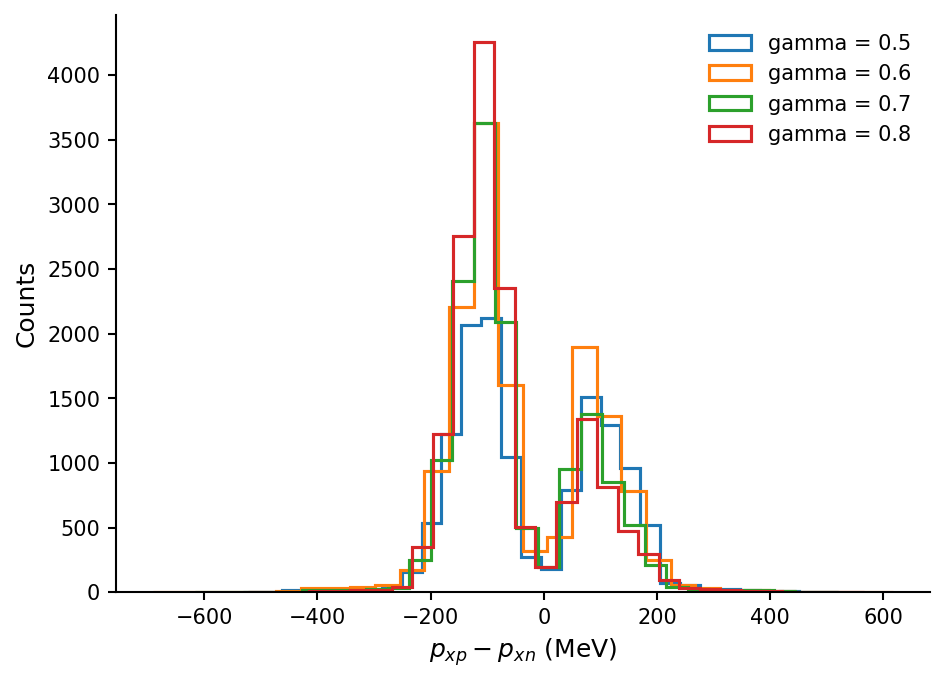

<Figure size 1200x900 with 0 Axes>

<Figure size 960x720 with 0 Axes>

In [9]:

import matplotlib.pyplot as plt
# 绘制图像





fig, ax = plt.subplots(figsize=(7, 5)) 
# 设置背景为白色
fig.patch.set_facecolor('white')  # 整个图表的背景颜色
ax.set_facecolor('white')         # 坐标轴区域的背景颜色
# 应用一些出版质量图表的常见样式偏好
plt.rcParams.update({
    "font.family": "sans-serif",       # 使用简洁的无衬线字体
    "font.sans-serif": ["Arial", "Helvetica", "DejaVu Sans"], # 优先选择的无衬线字体
    "axes.labelsize": 12,              # x 和 y 轴标签的字体大小
    "xtick.labelsize": 10,             # x 轴刻度标签的字体大小
    "ytick.labelsize": 10,             # y 轴刻度标签的字体大小
    "legend.fontsize": 10,             # 图例文字的字体大小
    "axes.titlesize": 14,              # 图表标题的字体大小
    "axes.linewidth": 1.0,             # 坐标轴线条（轴脊）的粗细
    "lines.linewidth": 1.5,            # 绘制线条的默认粗细
    "xtick.major.size": 4,             # x 轴主刻度线的长度
    "xtick.major.width": 1.0,          # x 轴主刻度线的粗细
    "ytick.major.size": 4,             # y 轴主刻度线的长度
    "ytick.major.width": 1.0,          # y 轴主刻度线的粗细
    "figure.dpi": 150,                 # 显示图表的默认DPI
})


i = 0
plt.figure(figsize=(8, 6))
for gamma in gammas:
    pxp_minus_pxn = np.array(pxp_values[gamma]) - np.array(pxn_values[gamma])
    ax.hist(pxp_minus_pxn, 
                bins=30,                      # 分箱数量 (根据需要调整)
                histtype='step',              # 关键：用于线型直方图
                linewidth=1.5,     # 直方图线条的粗细
                label=f'gamma = {gamma_lable[i]}')   # 图例标签 (如果gamma_key是LaTeX，会正确渲染)
    i += 1      
                # color=colors[i % len(colors)] # 取消注释以使用自定义颜色
                # color=color_map(i)            # 或者使用色彩映射的颜色
               

# --- 设置标题和标签，使用 LaTeX 排版数学符号 ---
# 在粒子物理中，px 通常指动量，单位可能是 MeV/c。
# 如果 pxp - pxn 代表能量差，则 MeV 是合适的。这里沿用您提供的 "MeV"。
# ax.set_title('Distribution of $p_{x,p} - p_{x,n}$ for Different Categories', fontsize=14, fontweight='normal') # 使用 LaTeX

ax.set_xlabel('$p_{xp} - p_{xn}$ (MeV)', fontsize=12) # 使用 LaTeX 和单位
ax.set_ylabel('Counts', fontsize=12)

# --- 图例 ---
# 放置图例，移除边框以获得更简洁的外观
# legend = ax.legend(frameon=False, loc='upper right', title='Category') # 
legend = ax.legend(frameon=False, loc='upper right') # title是可选的

#title是可选的
# legend.set_title('$\\gamma$ categories') # 如果您的类别是 gamma，可以这样设置图例标题

# --- 轴脊和刻度 ---
# 隐藏顶部和右侧的轴脊，使外观更简洁，符合“出版”风格
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# 确保底部和左侧的轴脊可见 (默认情况下它们是可见的)
ax.spines['left'].set_linewidth(1.0)
ax.spines['bottom'].set_linewidth(1.0)

# 自定义刻度参数 (例如，方向)
ax.tick_params(axis='both', which='major', direction='out') # 刻度线朝外

# --- 网格 ---
# 移除网格，或者在必要时使用非常浅色的网格。
# 原始代码中有 plt.grid(True)。对于 Nature/Science 风格，通常没有网格或只有微妙的y轴网格。
ax.grid(False) 
# 可选：如果需要一个微妙的水平网格:
# ax.yaxis.grid(True, linestyle=':', linewidth=0.6, color='lightgray', alpha=0.7)


# --- 最终布局调整 ---
# 调整布局以确保所有元素都适应良好，不会重叠
plt.tight_layout()
# plt.plot()
plt.savefig('output/pxp_minus_pxn_distribution.pdf', bbox_inches='tight')
plt.savefig('output/pxp_minus_pxn_distribution.png', bbox_inches='tight')
# --- 显示或保存图像 ---
plt.show()
plt.savefig('output/pxp_minus_pxn_distribution2.png', bbox_inches='tight')
plt.savefig('output/pxp_minus_pxn_distribution2.pdf', bbox_inches='tight')


FileNotFoundError: [Errno 2] No such file or directory: 'img/pxp_minus_pxn_distribution.pdf'

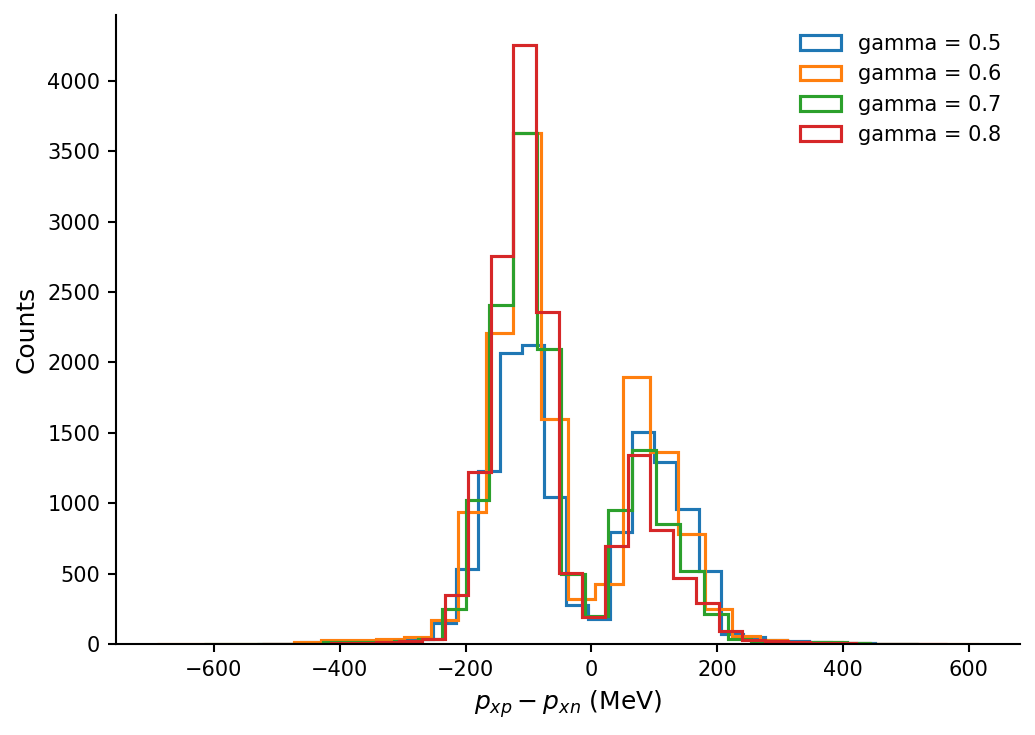

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Your data loading and rcParams settings remain the same

fig, ax = plt.subplots(figsize=(7, 5))
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

# Move plt.figure() outside the loop (and it's likely redundant now with plt.subplots)
# plt.figure(figsize=(8, 6))

i = 0
for gamma in gammas:
    pxp_minus_pxn = np.array(pxp_values[gamma]) - np.array(pxn_values[gamma])
    ax.hist(pxp_minus_pxn,
            bins=30,
            histtype='step',
            linewidth=1.5,
            label=f'gamma = {gamma_lable[i]}')
    i += 1

ax.set_xlabel('$p_{xp} - p_{xn}$ (MeV)', fontsize=12)
ax.set_ylabel('Counts', fontsize=12)
legend = ax.legend(frameon=False, loc='upper right')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.0)
ax.spines['bottom'].set_linewidth(1.0)
ax.tick_params(axis='both', which='major', direction='out')
ax.grid(False)
plt.tight_layout()

# Save the figure BEFORE showing it - 修复路径：img 改为 output
plt.savefig('output/pxp_minus_pxn_distribution.pdf', bbox_inches='tight')
plt.savefig('output/pxp_minus_pxn_distribution.png', bbox_inches='tight')

# Show the plot
plt.show()

<>:18: SyntaxWarning: invalid escape sequence '\g'
<>:46: SyntaxWarning: invalid escape sequence '\g'
<>:18: SyntaxWarning: invalid escape sequence '\g'
<>:46: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipykernel_195034/2049458873.py:18: SyntaxWarning: invalid escape sequence '\g'
  label=f'$\gamma$ = {gamma_lable[index]}')
/tmp/ipykernel_195034/2049458873.py:46: SyntaxWarning: invalid escape sequence '\g'
  label=f'$\gamma$ = {gamma_lable[index]}')


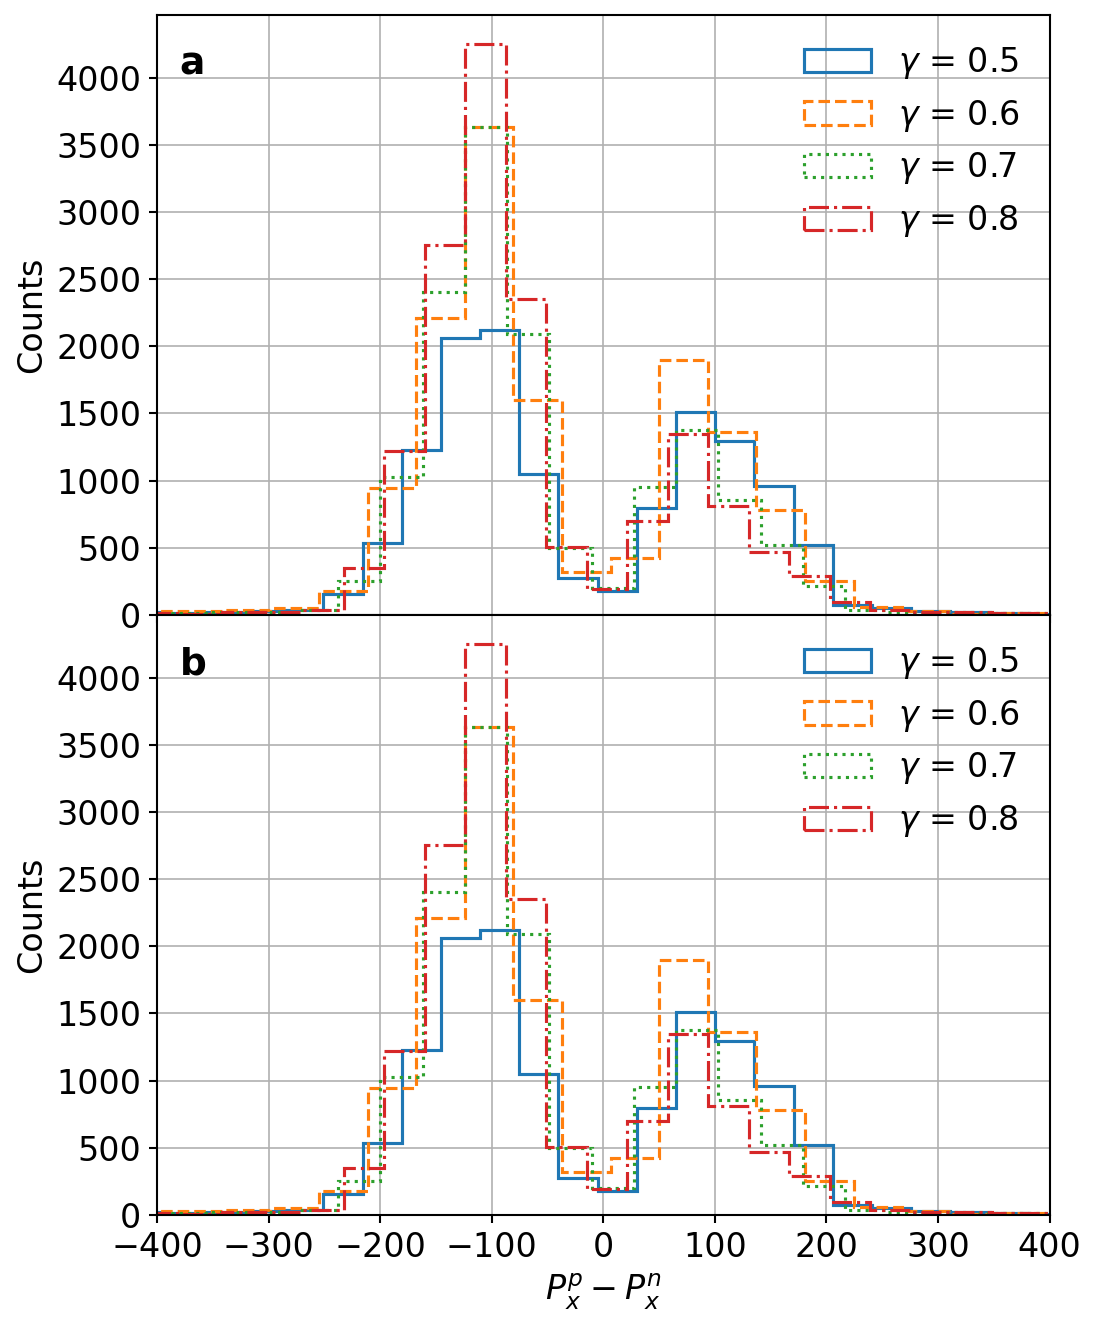

In [12]:
# 创建上下两幅图，共用横坐标
fig, axs = plt.subplots(2, 1, figsize=(7, 10), sharex=True, gridspec_kw={'hspace': 0})  # 设置 hspace=0 去除间隙
fig.patch.set_facecolor('white')

# 第一幅图
ax = axs[0]
line_styles = ['-', '--', ':', '-.']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for index, gamma in enumerate(gammas):
    pxp_minus_pxn = np.array(pxp_values[gamma]) - np.array(pxn_values[gamma])
    ax.hist(pxp_minus_pxn,
            bins=30,
            histtype='step',
            linewidth=1.5,
            linestyle=line_styles[index % len(line_styles)],
            color=colors[index],
            label=f'$\gamma$ = {gamma_lable[index]}')

ax.set_ylabel('Counts', fontsize=16)  # 增大 Y 轴标题字号
ax.legend(frameon=False, loc='upper right', fontsize=16)  # 增大
ax.spines['top'].set_visible(True)  # 显示顶部边框
ax.spines['right'].set_visible(True)  # 显示右侧边框
ax.spines['left'].set_linewidth(1.0)
ax.spines['bottom'].set_linewidth(1.0)
ax.spines['top'].set_linewidth(1.0)
ax.spines['right'].set_linewidth(1.0)
ax.tick_params(axis='both', which='major', direction='out', labelsize=16)  # 增大刻度数字字号
ax.grid(True)
ax.set_xlim(xmin=-400, xmax=400)
# 添加标注 "a"
ax.text(-380, ax.get_ylim()[1] * 0.9, 'a', fontsize=18, fontweight='bold')  # 左上角标注


# 第二幅图
ax = axs[1]
# 修复：使用相同的数据源，而不是未定义的 px_diff_data
for index, gamma in enumerate(gammas):
    pxp_minus_pxn = np.array(pxp_values[gamma]) - np.array(pxn_values[gamma])
    ax.hist(pxp_minus_pxn,
            bins=30,
            histtype='step',
            linewidth=1.5,
            linestyle=line_styles[index % len(line_styles)],
            color=colors[index % len(colors)],
            label=f'$\gamma$ = {gamma_lable[index]}')

ax.set_xlabel(r"$P_x^p - P_x^n$", fontsize=16)  # 增大 X 轴标题字号
ax.set_ylabel('Counts', fontsize=16)  # 添加 Y 轴标题
ax.legend(frameon=False, loc='upper right', fontsize=16)  # 增大图例字号
ax.spines['top'].set_visible(True)  # 显示顶部边框
ax.spines['right'].set_visible(True)  # 显示右侧边框
ax.spines['left'].set_linewidth(1.0)
ax.spines['bottom'].set_linewidth(1.0)
ax.spines['top'].set_linewidth(1.0)
ax.spines['right'].set_linewidth(1.0)
ax.tick_params(axis='both', which='major', direction='out', labelsize=16)  # 增大刻度数字字号
ax.grid(True)
ax.set_xlim(xmin=-400, xmax=400)  # 添加 xlim 设置
# 添加标注 "b"
ax.text(-380, ax.get_ylim()[1] * 0.9, 'b', fontsize=18, fontweight='bold')  # 左上角标注

# 调整布局，增加底部边距
plt.subplots_adjust(bottom=0.15, top=0.95, left=0.1, right=0.95)  # 手动调整边距，避免裁剪横坐标

# 修复路径：img 改为 output
plt.savefig('output/pxp_minus_pxn_distribution.pdf', bbox_inches='tight')
plt.savefig('output/pxp_minus_pxn_distribution.png', bbox_inches='tight')
# 显示图像
plt.show()

画出Pz和 p垂直于z的 二维直方图。 np 分别画多个图。 